# CoverMyMeds Data Science Project: Data Analysis

## Import the Data and Clean

I start my analysis by importing the data and performing some basic cleaning.

In [248]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

pharmacy_data_raw = pd.read_csv("pharmacy_tx.csv")

# recode variables
pharmacy_data = \
    pharmacy_data_raw \
    .assign(
        claim_status = pd.Categorical(pharmacy_data_raw.rejected),
        diagnosis = pd.Categorical(pharmacy_data_raw.diagnosis),
        drug = pd.Categorical(pharmacy_data_raw.drug),
        bin = pd.Categorical(pharmacy_data_raw.bin),
        pcn = pd.Categorical(pharmacy_data_raw.pcn),
        group = pd.Categorical(pharmacy_data_raw.group)
    )

pharmacy_data = \
    pharmacy_data \
    .assign(
        claim_status = lambda x: x.claim_status.cat.rename_categories({0: "Approved", 1: "Rejected"})
    )

# create month varaible
pharmacy_data = \
    pharmacy_data \
    .assign(
        tx_month = pd.DatetimeIndex(pharmacy_data["tx_date"]).month
    )

# drop rejected claims
pharmacy_data = pharmacy_data[pharmacy_data.claim_status == "Approved"]

pharmacy_data = \
    pharmacy_data \
    .assign(log_patient_pay = np.log(pharmacy_data_raw.patient_pay))


# the data set is too large for my local machine to run models on!
pharmacy_data = pharmacy_data.sample(n = 10000, random_state = 1)

/Users/nickjenkins/.pyenv/versions/3.10.4/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Create Train Test Split

Next, I split the data into training and testing partitions. 

In [249]:
# train-test split
pharmacy_train, pharmacy_test = train_test_split(
    pharmacy_data,
    shuffle = True,
    random_state = 1,
    test_size = 0.2
)

# Objective I: Predict Patient Copayments

## Model Building

### Model Specifications

With the data prepped, I now create the model specifications complete with several preprocessing steps. These steps include:

* Creating dummy variables for each categorical variable
* Grouping infrequently occurring diagnoses into an "Other Diagnoses" category

In [110]:
import sklearn.preprocessing as pre
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [111]:
nominal_features = ["diagnosis", "drug", "bin", "pcn", "group", "tx_month"]

nominal_pipeline = \
    Pipeline([
        ("onehot", pre.OneHotEncoder(handle_unknown = "ignore", min_frequency = 20))
    ])

preprocessing_pipeline = \
    ColumnTransformer([
        ("nominal_preprocessor", nominal_pipeline, nominal_features)
    ])

### Models

To predict patient copayments, I will use the following models:

* Regularized linear regression
* K-nearest neighbors
* Boosted tree
* Random forest
* Support vector machine

In [112]:
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
import xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [113]:
# linear regression
lasso_pipe = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("lasso", Lasso(random_state = 2))
])

# k-nearest neighbors
knn_pipe = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("knn", KNeighborsRegressor())
])

# xgboost
xbg_pipe = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("xgb", xgboost.XGBRegressor())
])

# random forest
rf_pipe = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("rf", RandomForestRegressor(n_estimators = 1000))
])

# support vector machine
svm_pipe = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("svm", SVR())
])

## Model Tuning and Fitting

### Define Parameter Grids

This section defines the parameter grids for model tuning. 

In [114]:
# set grid search parameters
alphas = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 25, 50, 100, 500]
param_range = [1, 5, 10, 15, 20, 25]
param_range_fl = [1.0, 0.75, 0.50, 0.25, 0.10]
n_estimators = [250, 750, 1250, 1750, 2000]
learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5]

# linear model parameter grid
lasso_param_grid = [
    {"lasso__alpha": alphas}
]

# knn parameter grid
knn_param_grid = [
    {"knn__n_neighbors": param_range,
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan"]}
]

# xgboost parameter grid
xgb_param_grid = [
    {"xgb__learning_rate": learning_rates,
    "xgb__max_depth": param_range,
    "xgb__min_child_weight": param_range[:2],
    "xgb__subsample": param_range_fl,
    "xgb__n_estimators": n_estimators}
]

# random forest parameter grid
rf_param_grid = {
    "rf__min_samples_leaf": param_range,
    "rf__min_samples_split": param_range[1:]
}

# support vector machine parameter grid
svm_param_grid = [
    {"svm__kernel": ["linear", "rbf"],
    "svm__C": param_range}
]

### Search Grids

Here we set up the parameter search grids. 

In [198]:
lasso_grid_search = \
    GridSearchCV(
        estimator = lasso_pipe,
        param_grid = lasso_param_grid,
        scoring = "neg_root_mean_squared_error",
        cv = 5,
        n_jobs = 4
    )

knn_grid_search = \
    GridSearchCV(
        estimator = knn_pipe,
        param_grid = knn_param_grid,
        scoring = "neg_root_mean_squared_error",
        cv = 5,
        n_jobs = 4
    )

xgboost_grid_search = \
    GridSearchCV(
        estimator = xbg_pipe,
        param_grid = xgb_param_grid,
        scoring = "neg_root_mean_squared_error",
        cv = 5,
        n_jobs = 4
    )

rf_grid_search = \
    GridSearchCV(
        estimator = rf_pipe,
        param_grid = rf_param_grid,
        scoring = "neg_root_mean_squared_error",
        cv = 5,
        n_jobs = 4
    )

svm_grid_search = \
    GridSearchCV(
        estimator = svm_pipe,
        param_grid = svm_param_grid,
        scoring = "neg_root_mean_squared_error",
        cv = 5,
        n_jobs = 4
    )

### Model Testing

Before fitting the models to the full training set, I first estimate them on a much smaller random sample of data from the training set to identify any model specification errors. This way I can more efficiently ensure that the models will run on the full data without issue. I use a racing approach to tune all models. 

In [199]:
import random
random.seed(2)

# test models on a smaller sample to identify errors
model_test_data = pharmacy_train.sample(1000)

lasso_grid_search.fit(
    X = model_test_data[nominal_features],
    y = model_test_data.log_patient_pay
)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('nominal_preprocessor',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        min_frequency=20))]),
                                                                         ['diagnosis',
                                                                          'drug',
                                                                          'bin',
                                                                          'pcn',
                                                                          'group',
                                                                          'tx_month'])])),
                                       ('lasso', Lasso(random_state=2))]),
             n_jobs=4, param_grid=[{'lasso__alpha': [1, 2, 3, 4, 5, 6]}],
             scoring='neg_root_mean_squared_error')

In [117]:
knn_grid_search.fit(
    X = model_test_data[nominal_features],
    y = model_test_data.log_patient_pay
)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('nominal_preprocessor',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        min_frequency=20))]),
                                                                         ['diagnosis',
                                                                          'drug',
                                                                          'bin',
                                                                          'pcn',
                                                                          'group',
                                                                          'tx_month'])])),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=4,
             param_grid=[{'knn__metric': ['euclidean', 'manhattan'],
                          'knn__n_neighbors': [1, 2, 3, 4, 5, 6],
                          'knn__weights': ['uniform', 'distance']}],
             scoring='neg_root_mean_squared_error')

In [118]:
xgboost_grid_search.fit(
    X = model_test_data[nominal_features],
    y = model_test_data.log_patient_pay
)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('nominal_preprocessor',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        min_frequency=20))]),
                                                                         ['diagnosis',
                                                                          'drug',
                                                                          'bin',
                                                                          'pcn',
                                                                          'group',
                                                                          'tx_month'])])),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsam...
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None,
                                                     reg_alpha=None,
                                                     reg_lambda=None, ...))]),
             n_jobs=4,
             param_grid=[{'xgb__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
                          'xgb__max_depth': [1, 2, 3, 4, 5, 6],
                          'xgb__min_child_weight': [1, 2],
                          'xgb__n_estimators': [250, 750, 1250, 1750, 2000],
                          'xgb__subsample': [1.0, 0.75, 0.5, 0.25, 0.1]}],
             scoring='neg_root_mean_squared_error')

In [71]:
rf_grid_search.fit(
    X = model_test_data[nominal_features],
    y = model_test_data.log_patient_pay
)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('nominal_preprocessor',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        min_frequency=20))]),
                                                                         ['diagnosis',
                                                                          'drug',
                                                                          'bin',
                                                                          'pcn',
                                                                          'group',
                                                                          'tx_month'])])),
                                       ('rf',
                                        RandomForestRegressor(n_estimators=1000))]),
             n_jobs=-1,
             param_grid={'rf__min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'rf__min_samples_split': [2, 3, 4, 5, 6]},
             scoring='neg_root_mean_squared_error')

In [72]:
svm_grid_search.fit(
    X = model_test_data[nominal_features],
    y = model_test_data.log_patient_pay
)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('nominal_preprocessor',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        min_frequency=20))]),
                                                                         ['diagnosis',
                                                                          'drug',
                                                                          'bin',
                                                                          'pcn',
                                                                          'group',
                                                                          'tx_month'])])),
                                       ('svm', SVR())]),
             n_jobs=-1,
             param_grid=[{'svm__C': [1, 2, 3, 4, 5, 6],
                          'svm__kernel': ['linear', 'rbf']}],
             scoring='neg_root_mean_squared_error')

### Full Model Fitting

Now I fit and tune the models to the full cross-validation folds. 

In [119]:
grids = [lasso_grid_search, knn_grid_search, xgboost_grid_search, rf_grid_search, svm_grid_search]

for models in grids:
    models.fit(
        X = pharmacy_train[nominal_features], 
        y = pharmacy_train.log_patient_pay
    )

import pickle
pickle.dump(grids, open("sklearn_reg_models.sav", 'wb'))

/Users/nickjenkins/.pyenv/versions/3.10.4/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/nickjenkins/.pyenv/versions/3.10.4/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


### Model Evaluation

With the models fit, we now explore the best results of each model to compare their performance. To do so, I'll make use of some code I found here [https://www.davidsbatista.net/blog/2018/02/23/model_optimization/](https://www.davidsbatista.net/blog/2018/02/23/model_optimization/) to convert the **scikit-learn** output to a data frame. 

In [165]:
models = pickle.load(open("sklearn_reg_models.sav", 'rb'))

In [208]:
results = []

for model in grids:
    results.append(np.abs(model.best_score_))

rmse_scores = pd.DataFrame(
    results, 
    columns = ["rmse"],
    index = ["Lasso", "KNN", "XGBoost", "Random Forest", "SVM"]
).sort_values("rmse")

rmse_scores

,rmse
XGBoost,0.148462
Random Forest,0.169219
SVM,0.187782
KNN,0.439062
Lasso,0.812565


The boosted tree had the lowest RMSE, closely followed by the random forest. We can also visually compare the best model specifications:

<AxesSubplot:ylabel='rmse'>

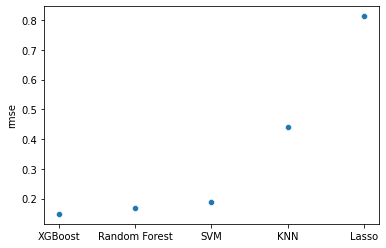

In [211]:
sns.scatterplot(
    y = "rmse",
    x = rmse_scores.index,
    data = rmse_scores
)

### Model Finalization

Let's examine the chosen parameters of the best performing model.

In [220]:
models[2].best_params_

{'xgb__learning_rate': 0.3,
 'xgb__max_depth': 6,
 'xgb__min_child_weight': 1,
 'xgb__n_estimators': 1750,
 'xgb__subsample': 1.0}

Now, we can use the tuned parameter values to finalize our model and fit the model to the full training set. 

In [240]:
final_pipe = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("xgb", xgboost.XGBRegressor(
        n_estimators = 1750,
        max_depth = 6, 
        min_child_weight = 1,
        subsample = 1.0,
        learning_rate = 0.3
    ))
])

final_pipe.fit(
    X = pharmacy_train[nominal_features], 
    y = pharmacy_train.log_patient_pay
)

pickle.dump(final_pipe, open("final_reg_fit.sav", 'wb'))

## Finalized Predictions

In [226]:
# we exponentiate the rmse to get the error rate in dollars
np.exp(final_pipe.score(pharmacy_test[nominal_features], pharmacy_test.log_patient_pay))

2.652199673745764

Our model can predict patient copayments within $2.65. 

We'll also examine the model's predictions plotted against the actual values:

In [251]:
preds = pd.DataFrame(
    np.exp(final_pipe.predict(pharmacy_test[nominal_features])),
    columns = ["prediction"]
)

full_data = \
    pharmacy_test \
    .reset_index() \
    .join(preds, how = "left")

Text(0, 0.5, 'Predicted Copayments')

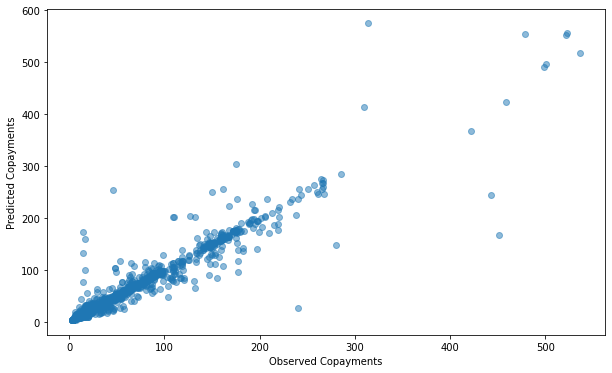

In [254]:
plt.figure(figsize=(12, 6))

plt.scatter(
    x = "patient_pay",
    y = "prediction",
    alpha = 0.5,
    data = full_data
)
plt.xlabel("Observed Copayments")
plt.ylabel("Predicted Copayments")

Now we examine the predicted copayments by diagnosis category: 

Text(0.5, 1.0, 'Open circles represent the observed copayment and the red circles show the predicted copayment.')

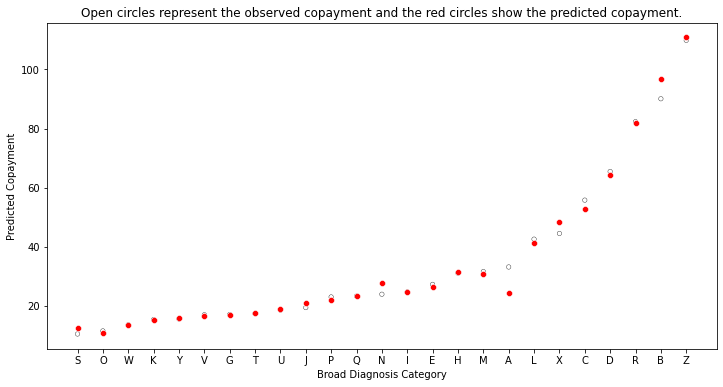

In [319]:
plot_data = \
    full_data \
    .assign(diagnosis_collapsed = full_data.diagnosis.str[0]) \
    .groupby("diagnosis_collapsed") \
    .aggregate({"patient_pay": "mean", "prediction": "mean"}) \
    .sort_values("patient_pay")

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x = "diagnosis_collapsed",
    y = "patient_pay",
    markers = "o",
    edgecolor = "black",
    facecolor = "none",
    data = plot_data
)

sns.scatterplot(
    x = "diagnosis_collapsed",
    y = "prediction",
    facecolor = "red",
    data = plot_data
)
plt.xlabel("Broad Diagnosis Category")
plt.ylabel("Predicted Copayment")
plt.title("Open circles represent the observed copayment and the red circles show the predicted copayment.")

Diagnosis "S" is predicted to have the lowest copayment on average at just over \$10, while diagnosis "Z" is predicted to have the highest with a value of about \$95. 

We can also visualize this figure broken down by the drug prescribed:

<Figure size 864x432 with 0 Axes>

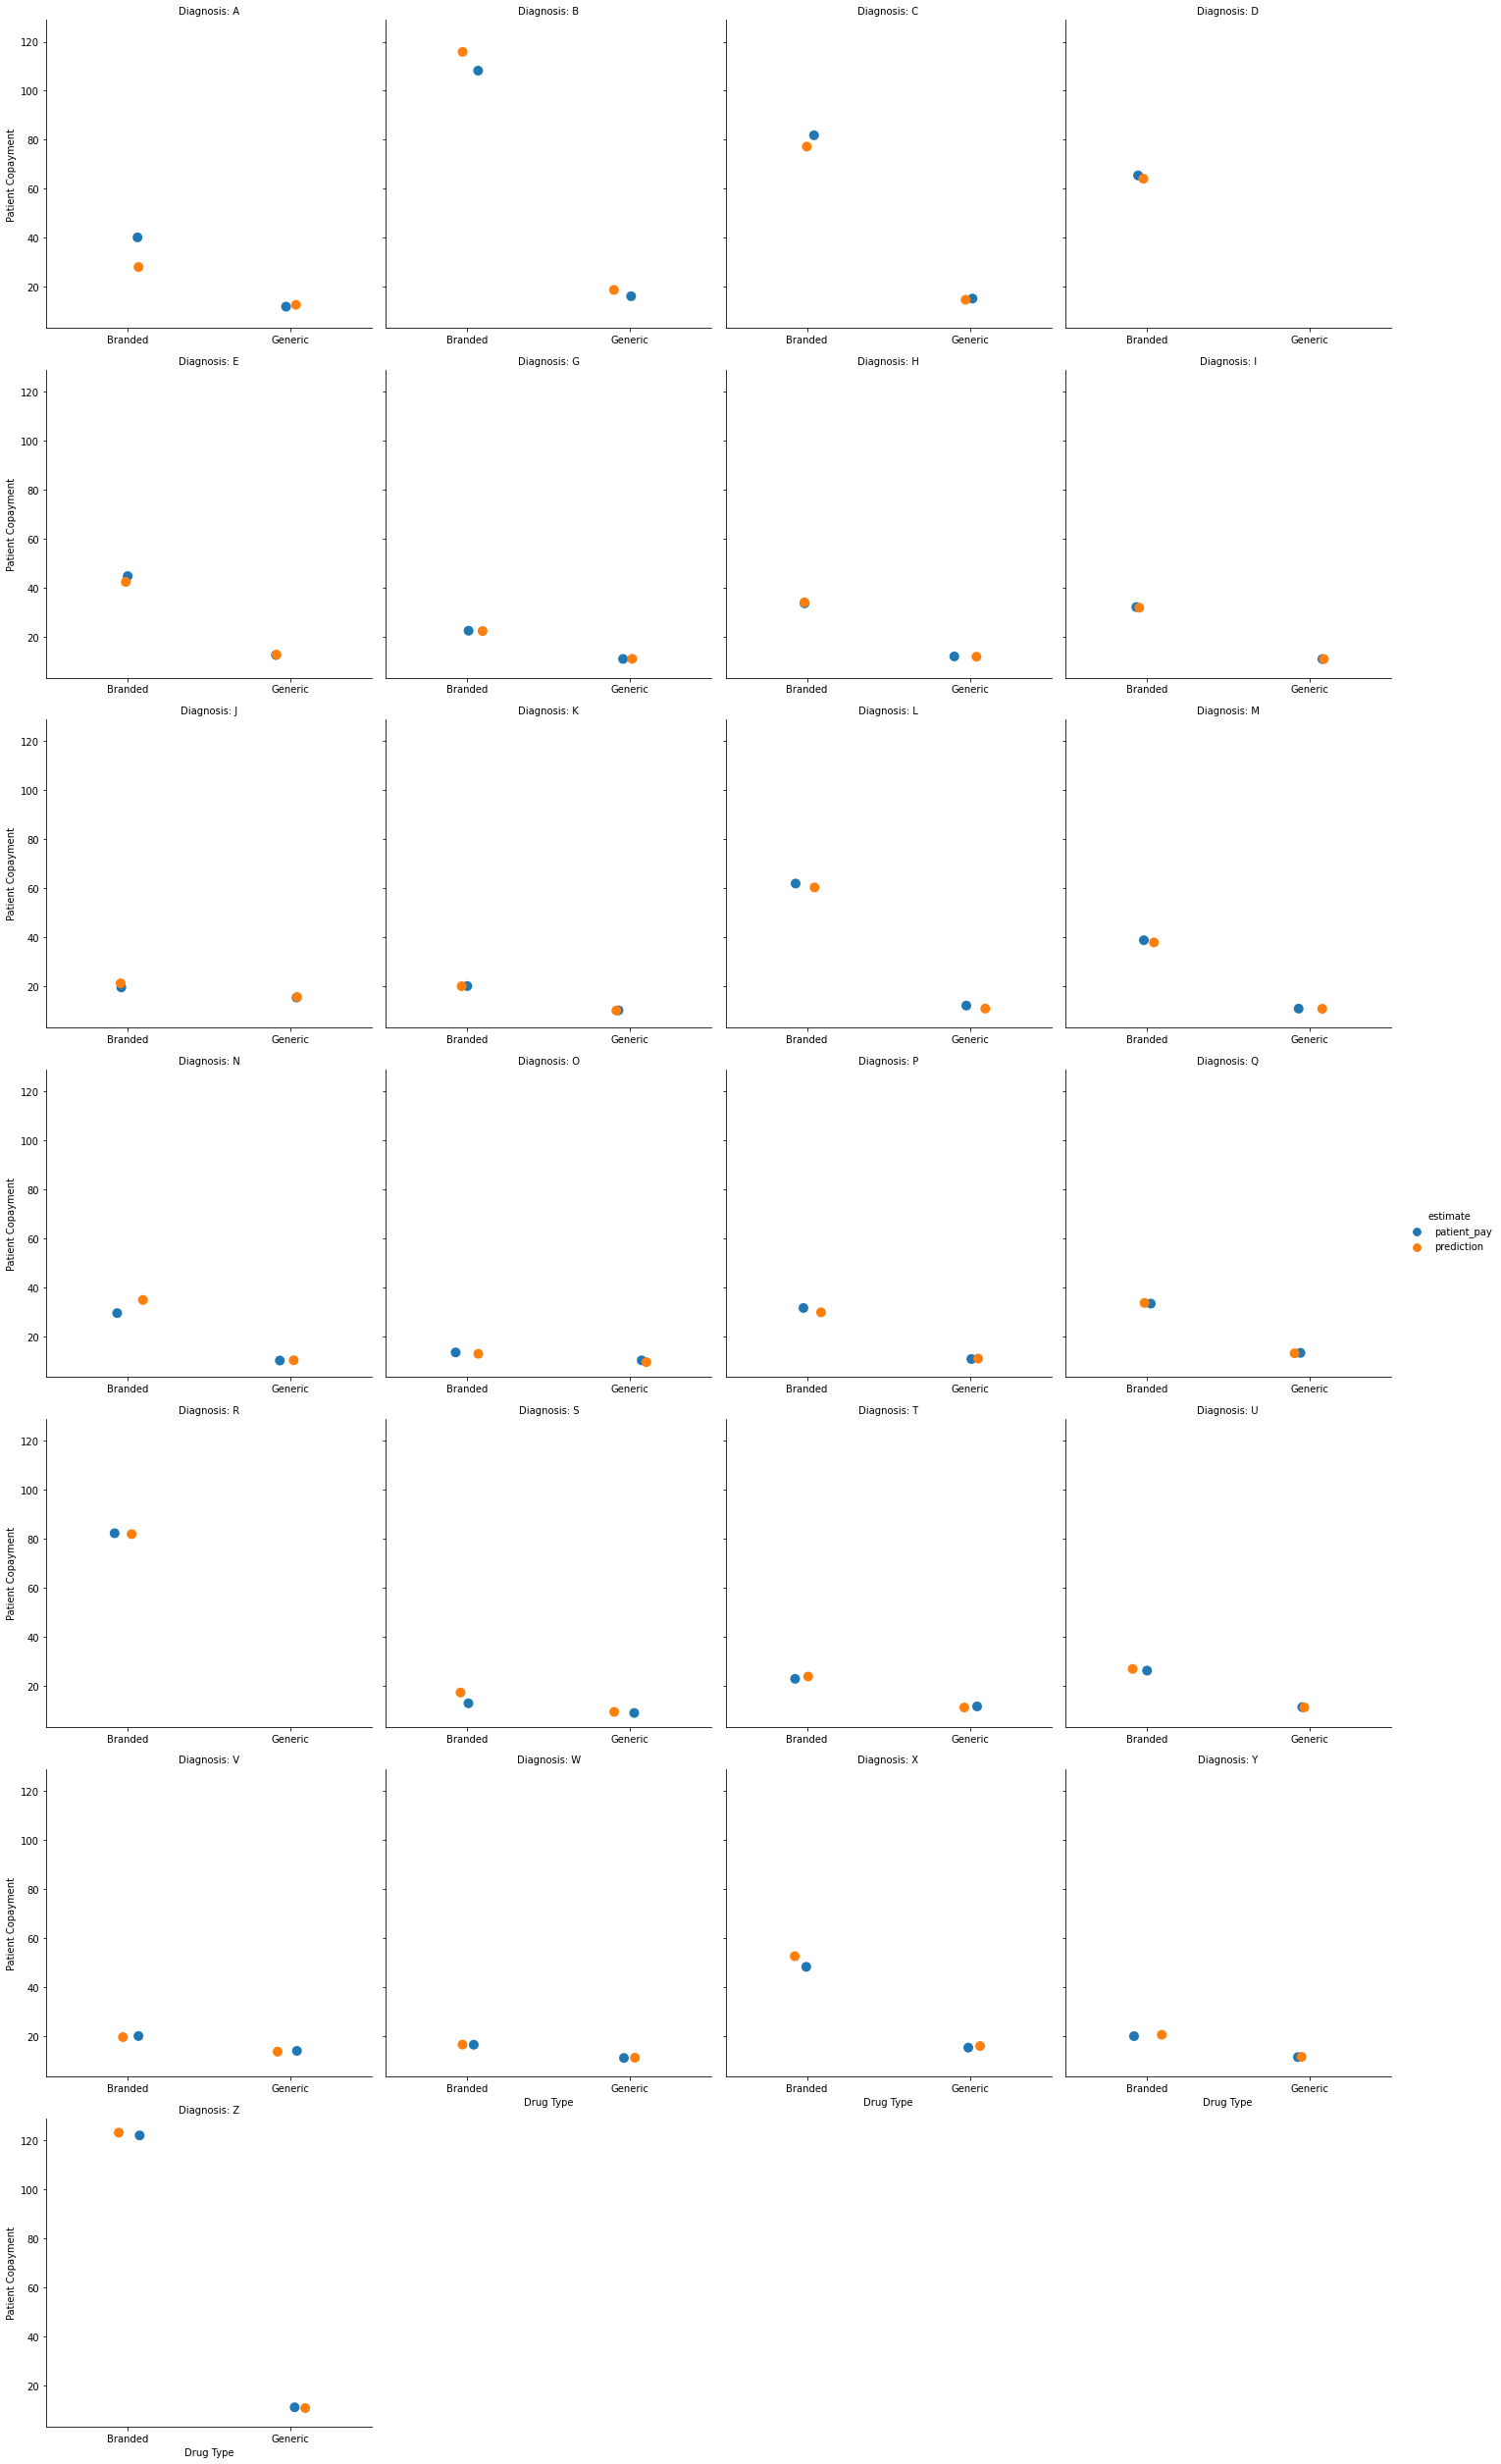

In [363]:
plot_data = \
    full_data \
    .assign(
        diagnosis_collapsed = full_data.diagnosis.str[0],
        generic_drug = pd.Categorical(np.where(full_data.drug.str.contains("generic"), 1, 0))
    )

plot_data = \
    plot_data \
    .assign(
        generic_drug = lambda x: x.generic_drug.cat.rename_categories({0: "Branded", 1: "Generic"})
    ) \
    .groupby(["diagnosis_collapsed", "generic_drug"]) \
    .aggregate({"patient_pay": "mean", "prediction": "mean"}) \
    .reset_index()

plot_data = plot_data.melt(
    id_vars = ["diagnosis_collapsed", "generic_drug"],
    var_name = "estimate",
    value_vars = ["patient_pay", "prediction"]
)

plt.figure(figsize=(12, 6))
g = sns.catplot(
    x = "generic_drug",
    y = "value",
    hue = "estimate",
    s = 10,
    col = "diagnosis_collapsed",
    col_wrap = 4,
    sharex = False,
    data = plot_data
)

(g.set_axis_labels("Drug Type", "Patient Copayment")
    .set_titles("Diagnosis: {col_name}")) 

Here we can see the predicted mean copayments by drug type (branded or generic) for each broad diagnosis category. 

Finally, we can examine the predicted copayment by insurance plan for each drug. 

<Figure size 864x432 with 0 Axes>

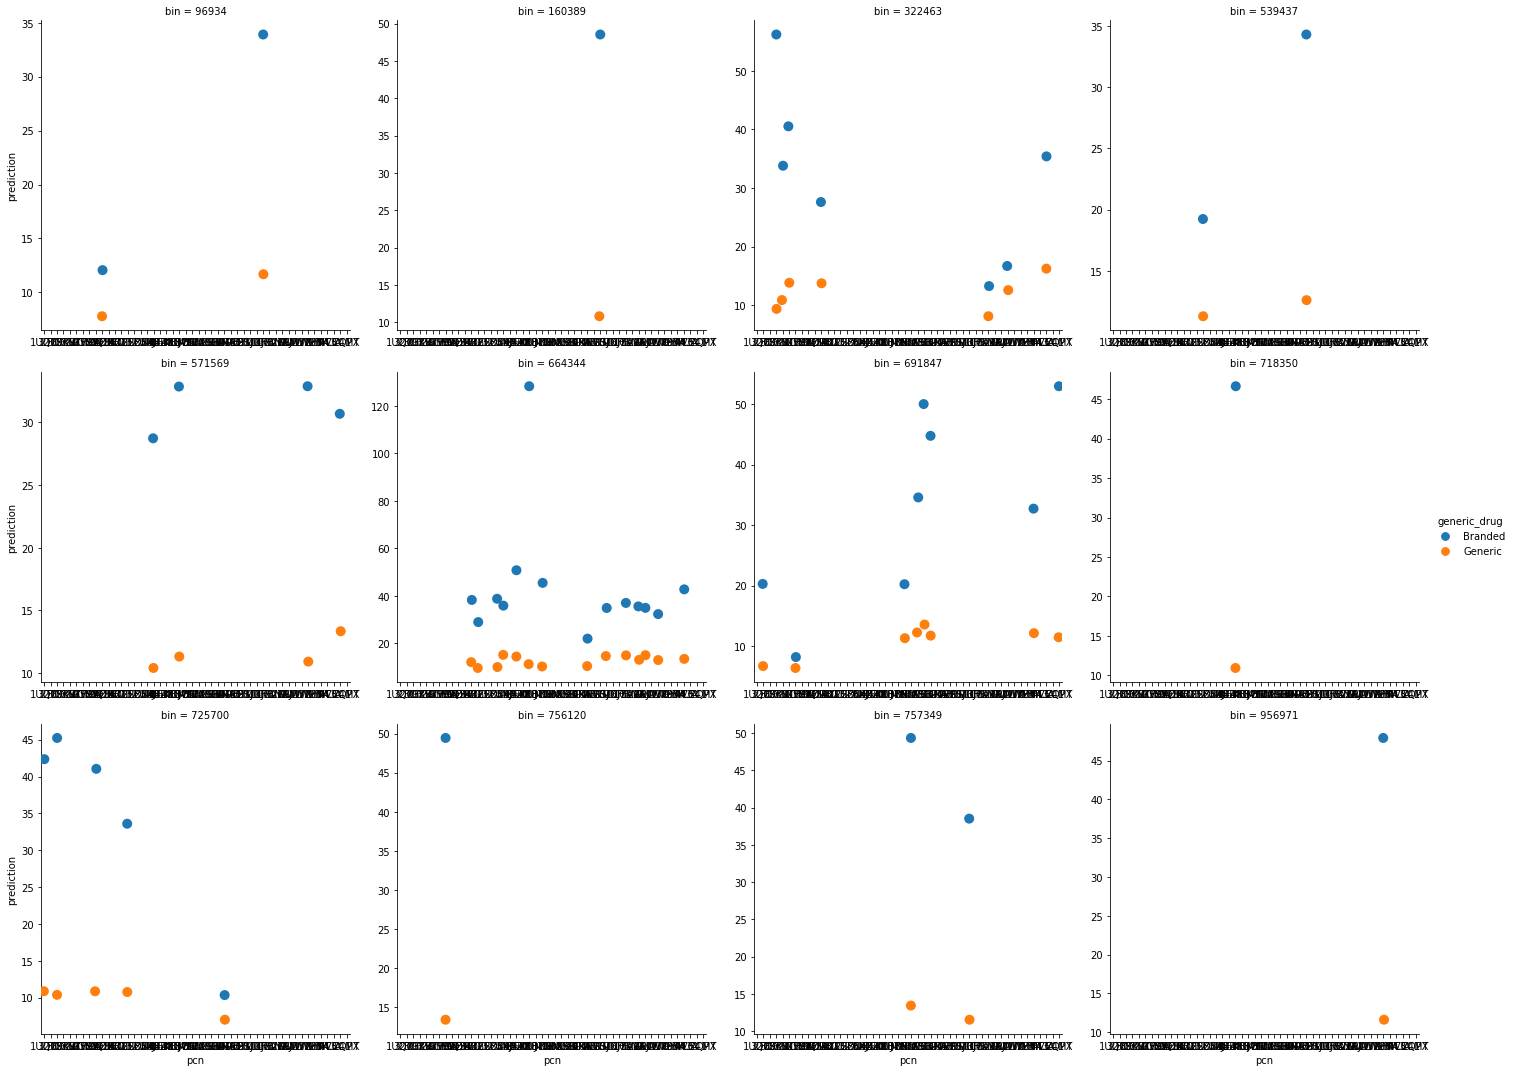

In [365]:
plot_data = \
    full_data \
    .assign(
        generic_drug = pd.Categorical(np.where(full_data.drug.str.contains("generic"), 1, 0))
    )

plot_data = \
    plot_data \
    .assign(
        generic_drug = lambda x: x.generic_drug.cat.rename_categories({0: "Branded", 1: "Generic"})
    ) \
    .groupby(["bin", "pcn", "generic_drug"]) \
    .aggregate({"patient_pay": "mean", "prediction": "mean"}) \
    .reset_index()

plt.figure(figsize=(12, 6))
sns.catplot(
    x = "pcn",
    y = "prediction",
    hue = "generic_drug",
    s = 10,
    col = "bin",
    col_wrap = 4,
    sharex = False,
    sharey = False,
    data = plot_data
)

(g.set_axis_labels("Drug Type", "Predicted Copayment")
    .set_titles("Diagnosis: {col_name}")) 

This figure shows the predicted copayment for branded and generic drugs under each insurance plan by `pcn` to provide a sense of how much a drug would cost under a detailed insurance plan. 

We could also examine the predicted copayment for specific drugs across insurance plans:

/var/folders/hm/klbdvmzd6mz_cqks_tjsp9d00000gn/T/ipykernel_13518/1610804351.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  drug_alt = full_data.drug.str.replace("generic|branded", "")


<Figure size 864x432 with 0 Axes>

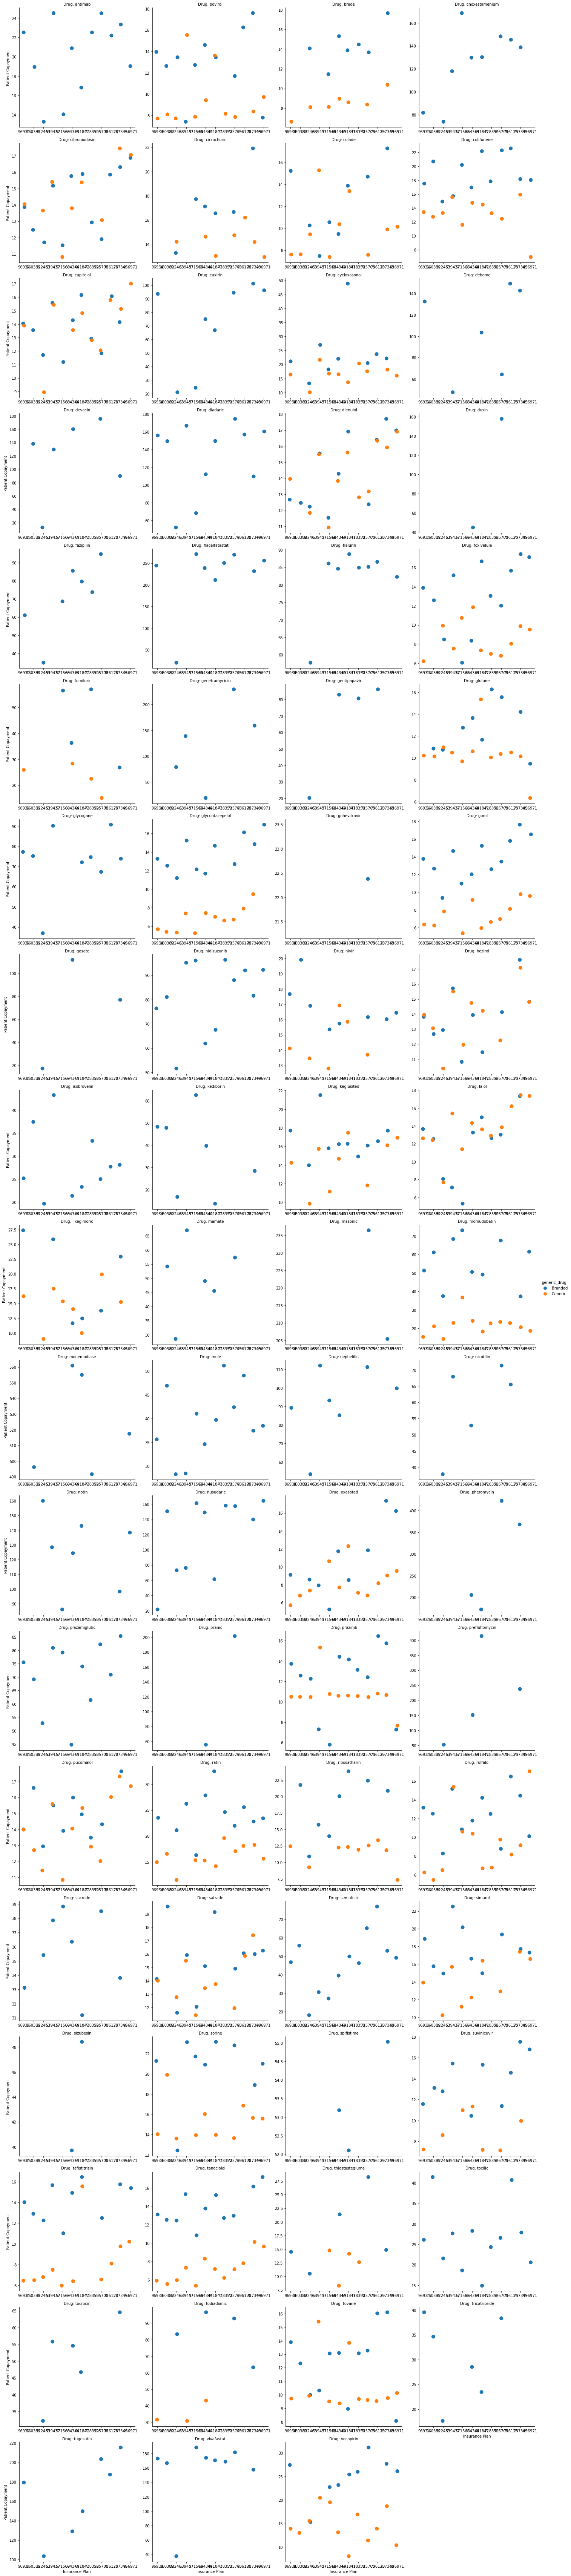

In [366]:
plot_data = \
    full_data \
    .assign(
        generic_drug = pd.Categorical(np.where(full_data.drug.str.contains("generic"), 1, 0)),
        drug_alt = full_data.drug.str.replace("generic|branded", "")
    ) \
    .assign(drug_alt = lambda x: x.drug_alt.str.strip()) 

plot_data = \
    plot_data \
    .assign(
        generic_drug = lambda x: x.generic_drug.cat.rename_categories({0: "Branded", 1: "Generic"})
    ) \
    .groupby(["bin", "drug_alt", "generic_drug"]) \
    .aggregate({"patient_pay": "mean", "prediction": "mean"}) \
    .reset_index()

plt.figure(figsize=(12, 6))
g = sns.catplot(
    x = "bin",
    y = "prediction",
    hue = "generic_drug",
    s = 10,
    col = "drug_alt",
    col_wrap = 4,
    sharex = False,
    sharey = False,
    data = plot_data
)

(g.set_axis_labels("Insurance Plan", "Predicted Copayment")
    .set_titles("Drug: {col_name}")) 

This plot shows predicted copayment of a given drug across insurance plans. To make it easier to digest, we could select a single drug to examine. Hivir, for example:

/var/folders/hm/klbdvmzd6mz_cqks_tjsp9d00000gn/T/ipykernel_13518/3552438332.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  drug_alt = full_data.drug.str.replace("generic|branded", "")


Text(0.5, 1.0, 'Open circles represent the observed copayment and the red circles show the predicted copayment.')

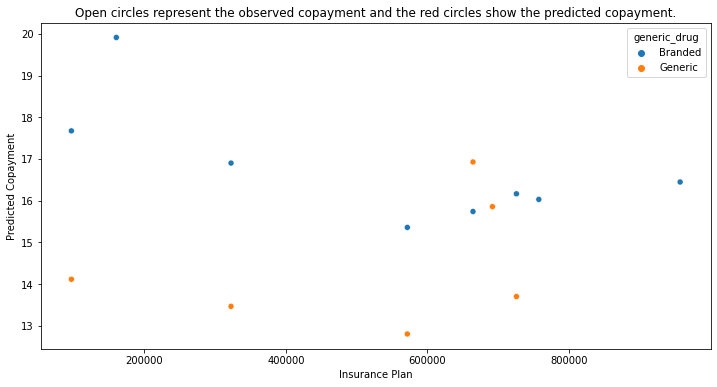

In [368]:
plot_data = \
    full_data \
    .assign(
        generic_drug = pd.Categorical(np.where(full_data.drug.str.contains("generic"), 1, 0)),
        drug_alt = full_data.drug.str.replace("generic|branded", "")
    ) \
    .assign(drug_alt = lambda x: x.drug_alt.str.strip()) 

plot_data = \
    plot_data \
    .assign(
        generic_drug = lambda x: x.generic_drug.cat.rename_categories({0: "Branded", 1: "Generic"})
    ) \
    .groupby(["bin", "drug_alt", "generic_drug"]) \
    .aggregate({"patient_pay": "mean", "prediction": "mean"}) \
    .reset_index()

plot_data = plot_data[plot_data.drug_alt == "hivir"]

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x = "bin",
    y = "prediction",
    hue = "generic_drug",
    data = plot_data
)
plt.xlabel("Insurance Plan")
plt.ylabel("Predicted Copayment")
plt.title("Open circles represent the observed copayment and the red circles show the predicted copayment.")

# Objective II: Predict the formulary status of the medication on each insurance plan

To accomplish this objective, we will use classification models to estimate the probability of an insurance claim being rejected or not. Then, we group these predicted probabilities into three groups to capture their formulary status according to rejected, non-preferred, and preferred:

* Predicted probabilities between $[0, 0.5)$ are grouped into the rejected group
* Predicted probabilities between $[0.5, 0.75)$ are grouped into the non-preferred group
* Predicted probabilities between $[0.75, 1.0]$ are grouped into the preferred group

With these groups, we can further determine whether each drug is a generic, preferred non-generic, non-preferred non-generic, etc.

To start, the rejected claims need to be added back to the data set and I will create a new train-test split and validation folds.

In [439]:
pharmacy_train.head()

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,claim_status,tx_month,log_patient_pay
5556656,2022-06-07,Pharmacy #47,U61.13,generic momudobatin,725700,1UQC,NaN,False,37.35,Approved,6,3.620333
11088122,2022-10-21,Pharmacy #36,K87.68,generic vocopirin,664344,NaN,52H8KH0F83K,False,6.11,Approved,10,1.809927
7189146,2022-07-18,Pharmacy #26,K87.68,branded cuxirin,725700,9C5MOR3,S2QKZ0OFNWS6X,False,99.85,Approved,7,4.603669
2776853,2022-03-22,Pharmacy #12,V80.87,branded cycloxasonol,322463,NaN,HO8HUGL,False,6.20,Approved,3,1.824549
2423061,2022-03-13,Pharmacy #35,Y51.55,branded sorine,664344,DY4B,NaN,False,20.74,Approved,3,3.032064


In [462]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

pharmacy_data_raw = pd.read_csv("pharmacy_tx.csv")

# recode variables
pharmacy_data = \
    pharmacy_data_raw \
    .assign(
        claim_status = pd.Categorical(pharmacy_data_raw.rejected),
        diagnosis = pd.Categorical(pharmacy_data_raw.diagnosis),
        drug = pd.Categorical(pharmacy_data_raw.drug),
        bin = pd.Categorical(pharmacy_data_raw.bin),
        pcn = pd.Categorical(pharmacy_data_raw.pcn),
        group = pd.Categorical(pharmacy_data_raw.group),
        claim_outcome = np.where(pharmacy_data_raw.rejected == True, 1, 0)
    )

pharmacy_data = \
    pharmacy_data \
    .assign(
        claim_status = lambda x: x.claim_status.cat.rename_categories({0: "Approved", 1: "Rejected"})
    )

# create month varaible
pharmacy_data = \
    pharmacy_data \
    .assign(
        tx_month = pd.DatetimeIndex(pharmacy_data["tx_date"]).month
    )


# the data set is too large for my local machine to run models on!
pharmacy_data = pharmacy_data.sample(n = 10000, random_state = 1)

# train-test split
pharmacy_train, pharmacy_test = train_test_split(
    pharmacy_data,
    shuffle = True,
    random_state = 1,
    test_size = 0.2,
    stratify = pharmacy_data["claim_status"]
)

## Model Building

### Model Specifications

With the data prepped, I now create the model specifications complete with several preprocessing steps. These steps include:

* Creating dummy variables for each categorical variable
* Grouping infrequently occurring diagnoses into an "Other Diagnoses" category

As such, I use the preprocesors above. 

### Models

To classify claim status, I will use the following models:

* K-nearest neighbors
* Binomial regression (with a Logit link function)
* Boosted tree
* Random forest
* Support vector machine

In [415]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [463]:
# k-nearest neighbors
knn_c_pipe = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("knn_c", KNeighborsClassifier())
])

# binomial regression
logit_pipe = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("logit", LogisticRegression(random_state = 2))
])

# xgboost
xbg_c_pipe = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("xgb_c", xgboost.XGBClassifier())
])

# random forest
rf_c_pipe = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("rf_c", RandomForestClassifier(n_estimators = 1000))
])

# support vector machine
svm_c_pipe = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("svm_c", SVC())
])

## Model Tuning and Fitting

### Define Parameter Grids

This section defines the parameter grids for model tuning. 

In [464]:
# set grid search parameters
neighbors = list(range(1, 40))
param_range = [1, 5, 10, 15, 20, 25]
param_range_fl = [1.0, 0.75, 0.50, 0.25, 0.10]
n_estimators = [250, 750, 1250, 1750, 2000]
learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5]

# knn parameter grid
knn_c_param_grid = [
    {"knn_c__n_neighbors": neighbors,
    "knn_c__weights": ["uniform", "distance"],
    "knn_c__metric": ["euclidean", "manhattan"]}
]

# binomial parameter grid
logit_param_grid = [
    {"logit__penalty": ["none", "l2", "l1", "elasticnet"],
    "logit__C": param_range}
]

# xgboost parameter grid
xgb_c_param_grid = [
    {"xgb_c__learning_rate": learning_rates,
    "xgb_c__max_depth": param_range,
    "xgb_c__min_child_weight": param_range[:2],
    "xgb_c__subsample": param_range_fl,
    "xgb_c__n_estimators": n_estimators}
]

# random forest parameter grid
rf_c_param_grid = {
    "rf_c__min_samples_leaf": param_range,
    "rf_c__min_samples_split": param_range[1:]
}

# support vector machine parameter grid
svm_c_param_grid = [
    {"svm_c__kernel": ["linear", "rbf"],
    "svm_c__C": param_range}
]

### Search Grids

Here we set up the parameter search grids. 

In [465]:
knn_c_grid_search = \
    GridSearchCV(
        estimator = knn_pipe,
        param_grid = knn_param_grid,
        scoring = "accuracy",
        cv = 5,
        n_jobs = 4
    )

logit_grid_search = \
    GridSearchCV(
        estimator = logit_pipe,
        param_grid = logit_param_grid,
        scoring = "accuracy",
        cv = 5,
        n_jobs = 4
    )

xgboost_c_grid_search = \
    GridSearchCV(
        estimator = xbg_c_pipe,
        param_grid = xgb_c_param_grid,
        scoring = "accuracy",
        cv = 5,
        n_jobs = 4
    )

rf_c_grid_search = \
    GridSearchCV(
        estimator = rf_c_pipe,
        param_grid = rf_c_param_grid,
        scoring = "accuracy",
        cv = 5,
        n_jobs = 4
    )

svm_c_grid_search = \
    GridSearchCV(
        estimator = svm_c_pipe,
        param_grid = svm_c_param_grid,
        scoring = "accuracy",
        cv = 5,
        n_jobs = 4
    )

### Model Testing

Before fitting the models to the full training set, I first estimate them on a much smaller random sample of data from the training set to identify any model specification errors. This way I can more efficiently ensure that the models will run on the full data without issue. I use a racing approach to tune all models. 

In [452]:
import random
random.seed(2)

# test models on a smaller sample to identify errors
model_test_data = pharmacy_train.sample(1000)

knn_c_grid_search.fit(
    X = model_test_data[nominal_features],
    y = model_test_data.claim_outcome
)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('nominal_preprocessor',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        min_frequency=20))]),
                                                                         ['diagnosis',
                                                                          'drug',
                                                                          'bin',
                                                                          'pcn',
                                                                          'group',
                                                                          'tx_month'])])),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=4,
             param_grid=[{'knn__metric': ['euclidean', 'manhattan'],
                          'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24, 25, 26,
                                               27, 28, 29, 30, ...],
                          'knn__weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [453]:
logit_grid_search.fit(
    X = model_test_data[nominal_features],
    y = model_test_data.claim_outcome
)

/Users/nickjenkins/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nickjenkins/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('nominal_preprocessor',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        min_frequency=20))]),
                                                                         ['diagnosis',
                                                                          'drug',
                                                                          'bin',
                                                                          'pcn',
                                                                          'group',
                                                                          'tx_month'])])),
                                       ('logit',
                                        LogisticRegression(random_state=2))]),
             n_jobs=4,
             param_grid=[{'logit__C': [1, 5, 10, 15, 20, 25],
                          'logit__penalty': ['none', 'l2', 'l1',
                                             'elasticnet']}],
             scoring='accuracy')

In [ ]:
xgboost_c_grid_search.fit(
    X = model_test_data[nominal_features],
    y = model_test_data.claim_outcome
)

In [454]:
rf_c_grid_search.fit(
    X = model_test_data[nominal_features],
    y = model_test_data.claim_outcome
)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('nominal_preprocessor',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        min_frequency=20))]),
                                                                         ['diagnosis',
                                                                          'drug',
                                                                          'bin',
                                                                          'pcn',
                                                                          'group',
                                                                          'tx_month'])])),
                                       ('rf_c',
                                        RandomForestClassifier(n_estimators=1000))]),
             n_jobs=4,
             param_grid={'rf_c__min_samples_leaf': [1, 5, 10, 15, 20, 25],
                         'rf_c__min_samples_split': [5, 10, 15, 20, 25]},
             scoring='accuracy')

In [455]:
svm_c_grid_search.fit(
    X = model_test_data[nominal_features],
    y = model_test_data.claim_outcome
)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('nominal_preprocessor',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        min_frequency=20))]),
                                                                         ['diagnosis',
                                                                          'drug',
                                                                          'bin',
                                                                          'pcn',
                                                                          'group',
                                                                          'tx_month'])])),
                                       ('svm_c', SVC())]),
             n_jobs=4,
             param_grid=[{'svm_c__C': [1, 5, 10, 15, 20, 25],
                          'svm_c__kernel': ['linear', 'rbf']}],
             scoring='accuracy')

### Full Model Fitting

Now I fit and tune the models to the full cross-validation folds. 

In [466]:
c_grids = [knn_c_grid_search, logit_grid_search, xgboost_c_grid_search, rf_c_grid_search, svm_c_grid_search]

for models in c_grids:
    models.fit(
        X = pharmacy_train[nominal_features], 
        y = pharmacy_train.claim_outcome
    )

import pickle
pickle.dump(c_grids, open("sklearn_c_models.sav", 'wb'))